In [1]:
from datetime import date, datetime
from math import sqrt, exp, log, pi
import os

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate as integrate
import pandas as pd
from pymc3 import  *

# Пункт 1

In [2]:
PATH_TO_READ = "./owid-covid-data.csv"
COUNTRY_NAME = "Russia"
FIRST_DATE_STRING = "2020-03-03"
TRAIN_DAYS_NUM = 50
REPLACE_ZERO_NEW_CASES = True

In [3]:
FIRST_DATE = datetime.strptime(FIRST_DATE_STRING, '%Y-%m-%d').date()

In [4]:
data = pd.read_csv(PATH_TO_READ)
data.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [5]:
data["date"] = pd.to_datetime(data["date"])
data = data.loc[(data["location"] == COUNTRY_NAME) & (data["date"] >= FIRST_DATE_STRING)].copy()

In [6]:
if REPLACE_ZERO_NEW_CASES:
    data["new_cases"] = np.where(data["new_cases"] != 0, data["new_cases"], 1)

In [7]:
first_test_date = np.sort(data["date"].unique())[TRAIN_DAYS_NUM]
train_data = data.loc[data["date"] < first_test_date].copy()
test_data = data.loc[data["date"] >= first_test_date].copy()

In [ ]:
train_data["day_num"] = range(len(train_data))
data["day_num"] = range(len(data))

# Пункт 2

## Графики целевых переменных

<Figure size 432x288 with 0 Axes>

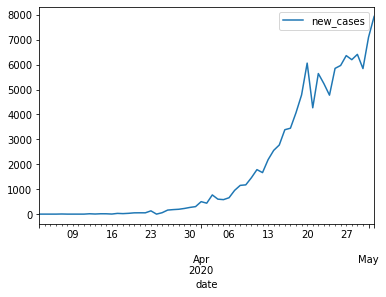

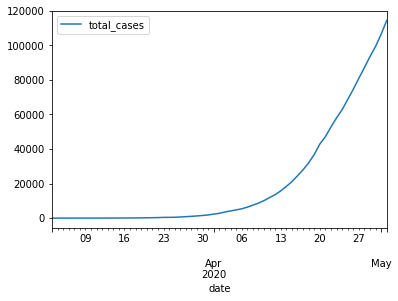

In [72]:
plt.figure();

data.plot(x="date", y="new_cases");
data.plot(x="date", y="total_cases");

## Экспоненциальная модель

Рассмотрим экспоненциальную модель

$$ N(t) = \exp \left( a \cdot t + b \right) , $$

где $t$ --- количество прошедшех дней от точки старта наблюдения, $N$ --- количество заболевших человек, $a$ и $b$ --- искомые параметры.

Приведем модель к линейному виду:

$$ \ln N(t) =   a \cdot t + b . $$

На графике ниже построен логарифм числа заболевших от времени для визуального подтверждения того, что эта зависимость может быть описана линейной зависимостью по крайней мере на рассматриваемом промежутке времени.

<Figure size 432x288 with 0 Axes>

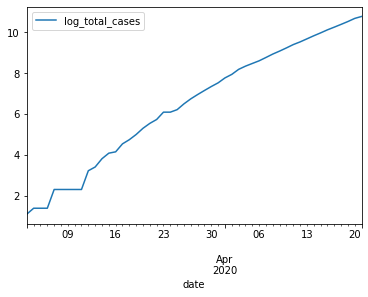

In [10]:
train_data["log_new_cases"] = np.log(train_data["new_cases"])
train_data["log_total_cases"] = np.log(train_data["total_cases"])

plt.figure();
train_data.plot(x="date", y="log_total_cases");

Для оценки параметров полученной линейной зависимости воспользуемся линейной регрессией.

$$ \ln N(t) =   a \cdot t + b + \varepsilon, $$

$$ \varepsilon \sim \mathbf{N} (0, \sigma). $$

Итого получается 3 неизвестных параметра $a$, $b$, $\sigma$. Оценим их апостериорные распределения, взяв в качестве априорных следуещие:
$$ a \sim \mathbf{N} (0, 20), $$
$$ b \sim \mathbf{N} (0, 20), $$
$$ \sigma \sim \mathbf{U} [0, 50]. $$

In [12]:
with Model() as model:
    # Define priors
    sigma = Uniform('sigma', lower=0, upper=50)
    b = Normal('b', 0, sigma=20)
    a = Normal('a', 0, sigma=20)

    # Define likelihood
    likelihood = Normal(
        'y',
        mu=b + a * train_data["day_num"],
        sigma=sigma,
        observed=train_data["log_total_cases"],
    )

    # Inference
    trace = sample(10_000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:12<00:00, 1679.33draws/s]
The acceptance probability does not match the target. It is 0.8965348616402924, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8943561778678598, but should be close to 0.8. Try to increase the number of tuning steps.


/home/mikhail/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 504x504 with 0 Axes>

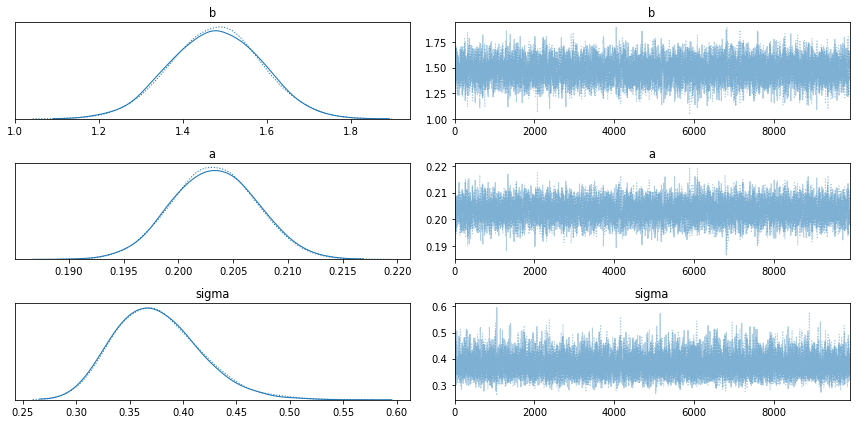

In [13]:
plt.figure(figsize=(7, 7))
traceplot(trace[100:])
plt.tight_layout();

In [14]:
num_samples = 1000

params_posterior_samples = {
    'b': trace['b'][-num_samples:],
    'a': trace['a'][-num_samples:]
}

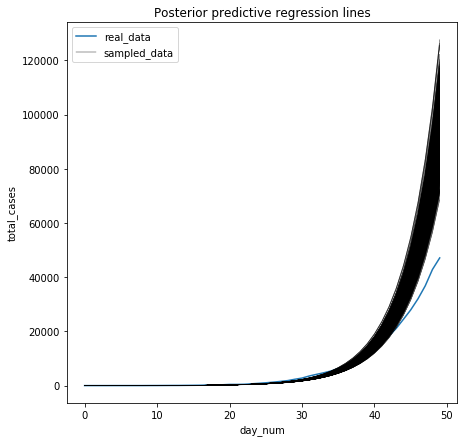

In [15]:
plt.figure(figsize=(7, 7))
plt.plot(train_data["day_num"], train_data["total_cases"], label='real_data')

plt.plot(
    train_data["day_num"],
    np.exp(params_posterior_samples["b"][0] + params_posterior_samples["a"][0] * train_data["day_num"]),
    'k-',
    lw=.4,
    label='sampled_data'
)
for i in range(1, num_samples):
    plt.plot(
        train_data["day_num"],
        np.exp(params_posterior_samples["b"][i] + params_posterior_samples["a"][i] * train_data["day_num"]),
        'k-',
        lw=.4
    )

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('day_num')
plt.ylabel('total_cases');

## Прогноз количества случаев коронавируса на 1 мая, 1 июня и 1 сентября

In [17]:
dates_to_predict = [date(2020, 5, 1), date(2020, 6, 1), date(2020, 9, 1)]

In [18]:
day_nums_to_predict = [
    (date_to_predict - FIRST_DATE).days for date_to_predict in dates_to_predict
]

day_nums_to_predict

[59, 90, 182]

In [19]:
preds_for_dates = np.zeros((len(day_nums_to_predict), num_samples))

In [20]:
for row_index, day_num in enumerate(day_nums_to_predict):
    for i in range(num_samples):
        preds_for_dates[row_index, i] = np.exp(
            params_posterior_samples["b"][i] + params_posterior_samples["a"][i] * day_num
        )

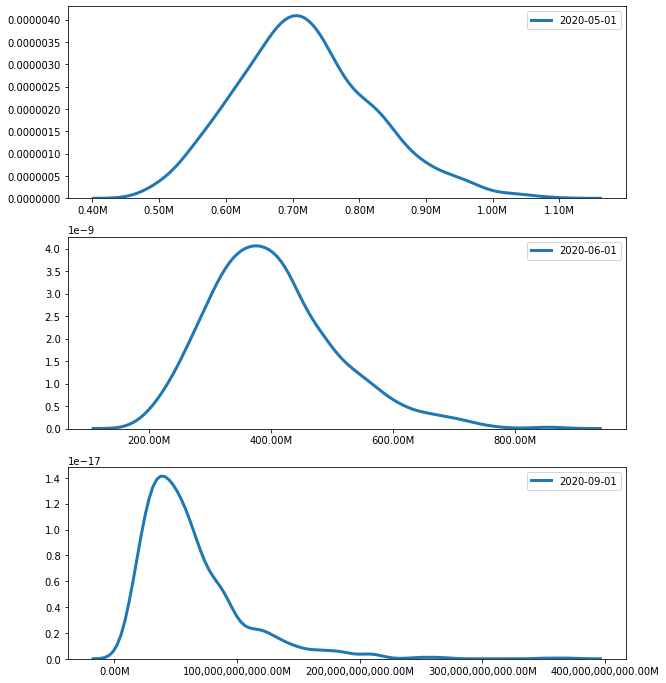

In [21]:
fig, ax = plt.subplots(len(dates_to_predict), figsize=(10, len(dates_to_predict) * 4))
graphs = []
for i, date_to_predict in enumerate(dates_to_predict):
    g = sns.distplot(
        preds_for_dates[i],
        hist = False,
        kde = True,
        kde_kws = {'linewidth': 3},
        label = dates_to_predict[i],
        ax=ax[i]
    );
    xlabels = ['{:,.2f}'.format(x) + 'M' for x in g.get_xticks() / 1_000_000]
    g.set_xticklabels(xlabels);

Прогнозы на 1 июня и 1 сентября выглядят совсем не правдоподобно, т.к. прогнозируемое количество больных сильно превышает актуальное количество жителей страны. Это является следствием того, что в рамках данной задачи экспоненциальная модель не подходит для целей экстраполяции (очевидно, что в какой-то момент количество заболевших выйдет на плато, но экспоненциальная модель не предполагает изменения характера выпуклости функции).

# Пункт 3

По примеру из работы [[Murray, 2020]](https://www.medrxiv.org/content/10.1101/2020.03.27.20043752v1) (приведенной в условии задания) для моделирования числа заболевших используем кумулятивную функцию нормально распределения вида:
    
$$  N(t) = \frac{K}{2} \left[ 1 + \frac{2}{\sqrt{\pi}} \int_{0}^{a t + b} \exp(-\tau^2) d\tau \right] . $$

Здесь добавился параметр $K$, отвечающий за максимальное количество заболевших.

Линеаризуем данную зависимость:

$$  N(t) = \frac{K}{2} \left[ 1 + \frac{2}{\sqrt{\pi}} \int_{0}^{a t + b} \exp(-\tau^2) d\tau \right] = $$

$$  = \frac{K}{2} + \exp \left[ \ln \frac{K}{\sqrt{\pi}} \right] \cdot \int_{0}^{a t + b} \exp(-\tau^2) d\tau = \left[ K' = \ln \frac{K}{\sqrt{\pi}}, K = e^{K'} \cdot \sqrt{\pi} \right] = $$

$$  = \frac{K}{2} + \int_{0}^{a t + b} \exp\left(-\tau^2 + K'\right) d\tau . $$

Для того, чтобы избавиться от знака интеграла, возьмем производную по времени от левой и правой частей:

$$ \frac{dN(t)}{dt} = \frac{dN(at + b)}{d(at + b)} \cdot \frac{d(at + b)}{dt} = a \cdot \exp\left[-(at+b)^2 + K'\right] = \exp\left[-(at+b)^2 + K' + \ln a \right] . $$

В качестве данных о значениях производной по времени будем использовать количество новых случаев коронавируса за сутки.

Как и в предыдущем случае, для линеаризации правой части возьмем логарифм от обеих частей равенства:

$$ \ln \frac{dN(t)}{dt} = -(at+b)^2 + K' + \ln a . $$

Справа получился квадратичный многочлен от $t$. Для того, чтобы оценить параметры этого многочлена с помощью линейной регрессии, приведем многочлен к линейному по параметрам виду:

$$ -(at+b)^2 + K' + \ln a = At^2 + Bt + C , $$

откуда получим:

$$ a = \sqrt{-A} , $$

$$ b = \frac{B}{-2a} , $$

$$ K' = C + b^2 - \ln a . $$

Заметим, что оцениваемый с помощью линейной регрессии параметр $A$ должен быть отрицательным, соответсветственно, учтем это, взяв в качестве априорного распределения параметра $A$ распределение с носителем в отрицательной части пространства действительных чисел.

Также отметим, что коэффициент $K$, отражающий оценку общего количества заболевших в России, не может превышать населения России. Так как этот параметр связан с параметрами линейной регрессии сложной нелинейной зависимостью, не будем пытаться учесть ограничение на параметр $K$ в априорных распределениях параметров $A, B, C$, а просто отфильтруем соответствующие сэмплы при генерации значений параметров из оцененного апостериорного распределения.

Снова построим график целевой переменной от времени (график ниже). На графике наблюдаются провалы, когда не фиксировались новые случаи заболевания. Для более качественной оценки параметров исключим данные наблюдения.

<Figure size 432x288 with 0 Axes>

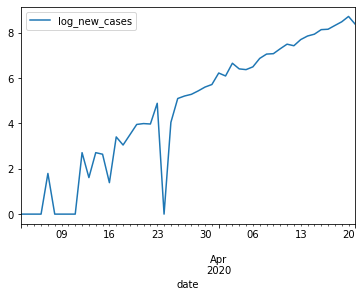

In [23]:
plt.figure();
train_data.plot(x="date", y="log_new_cases");

График зависимой переменной линейной регрессии без "сильных" выбросов вниз.

<Figure size 432x288 with 0 Axes>

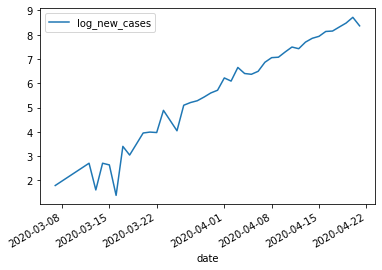

In [24]:
plt.figure();
train_data.loc[train_data["new_cases"] > 1].plot(x="date", y="log_new_cases");

In [63]:
%%time

day_nums = train_data.loc[train_data["new_cases"] > 1, "day_num"].values
log_new_cases = train_data.loc[train_data["new_cases"] > 1, "log_new_cases"].values
with Model() as model:
    # Define priors
    sigma = Uniform('sigma', lower=0, upper=10)
    C = Normal('C', 0, sigma=10)
    B = Normal('B', 0, sigma=10)
    A = Uniform('A', lower=-1, upper=0)

    # Define likelihood
    likelihood = Normal(
        'y',
        mu=(C + B * day_nums + A * day_nums ** 2),
        sigma=sigma,
        observed=log_new_cases,
    )

    # Inference
    trace = sample(100_000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, B, C, sigma]
Sampling 2 chains, 34 divergences: 100%|██████████| 201000/201000 [10:02<00:00, 333.62draws/s]
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8855980319746143, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


CPU times: user 1min 28s, sys: 4.01 s, total: 1min 32s
Wall time: 10min 28s


/home/mikhail/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 504x504 with 0 Axes>

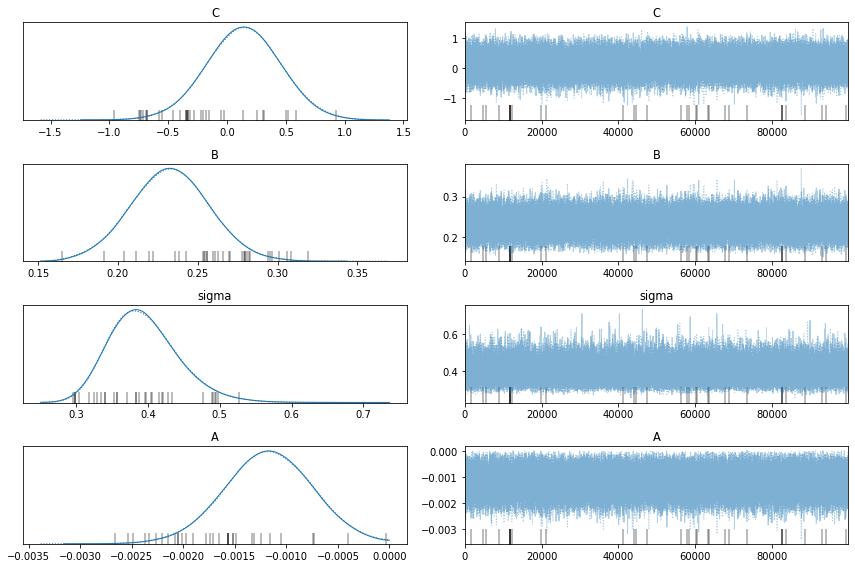

In [64]:
plt.figure(figsize=(7, 7))
traceplot(trace[100:])
plt.tight_layout();

In [73]:
# сэмплирование коэффициентов линейной регрессии из апостериорного распределения
num_samples = 1000

lin_params_posterior_samples = {
    'C': trace['C'][-num_samples:],
    'B': trace['B'][-num_samples:],
    'A': trace['A'][-num_samples:]
}

In [109]:
# оценка параметров исходной зависимости N(t) по значениям параметров линейной регрессии
params_posterior_samples = {}
params_posterior_samples['a'] = np.sqrt(-lin_params_posterior_samples['A'])
params_posterior_samples['b'] = -lin_params_posterior_samples['B'] / 2 / params_posterior_samples['a']
k_hat = lin_params_posterior_samples['C'] + params_posterior_samples['b']**2 - np.log(params_posterior_samples['a'])
params_posterior_samples['k'] = np.exp(k_hat) * np.sqrt(pi)

In [110]:
# фильтр сэмплов значений параметров по ограничению по количеству жителей России
mask = (params_posterior_samples['k'] < 145e6)

params_posterior_samples['a'] = params_posterior_samples['a'][mask].copy()
params_posterior_samples['b'] = params_posterior_samples['b'][mask].copy()
k_hat = k_hat[mask].copy()
params_posterior_samples['k'] = params_posterior_samples['k'][mask]

In [115]:
def predict_total_cases_for_one_day(day_num, a, b, k):
    integral = integrate.quad(lambda x: np.exp(-x**2), 0, a * day_num + b)[0]
    result = k / 2 * (1 + 2 / sqrt(pi) * integral)
    return result

predict_total_cases_for_several_days = np.vectorize(predict_total_cases_for_one_day)

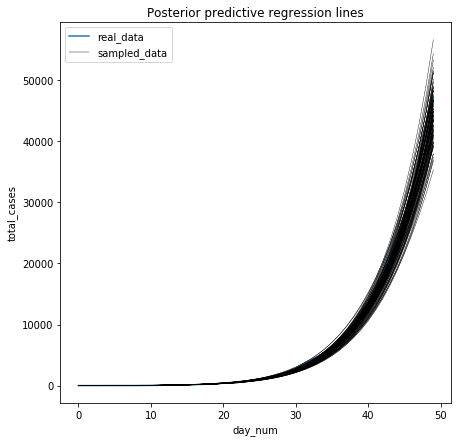

In [118]:
plt.figure(figsize=(7, 7))
plt.plot(train_data["day_num"], train_data["total_cases"], label='real_data')

plt.plot(
    train_data["day_num"],
    predict_total_cases_for_several_days(
        train_data["day_num"],
        params_posterior_samples['a'][0],
        params_posterior_samples['b'][0],
        params_posterior_samples['k'][0],
    ),
    'k-',
    lw=.4,
    label='sampled_data'
)
for i in range(1, 100):
    plt.plot(
        train_data["day_num"],
        predict_total_cases_for_several_days(
            train_data["day_num"],
            params_posterior_samples['a'][i],
            params_posterior_samples['b'][i],
            params_posterior_samples['k'][i],
        ),
        'k-',
        lw=.4,
    )

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('day_num')
plt.ylabel('total_cases');

### Сколько всего случаев коронавируса в России?

586044


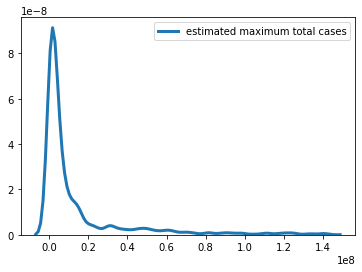

In [129]:
g = sns.distplot(
    params_posterior_samples['k'],
    hist = False,
    kde = True,
    kde_kws = {'linewidth': 3},
    label = 'estimated maximum total cases',
);

In [134]:
optim_forecast  = int(np.percentile(params_posterior_samples['k'], 10))
pessim_forecast = int(np.percentile(params_posterior_samples['k'], 90))

print("прогноз числа случаев коронавируса в оптимистичном сценарии: ", optim_forecast)
print("прогноз числа случаев коронавируса в пессимистичном сценарии:", pessim_forecast)

прогноз числа случаев коронавируса в оптимистичном сценарии:  586044
прогноз числа случаев коронавируса в пессимистичном сценарии: 42915334


# Пункт 5
## Ответы на вопросы

**Что я понял из этого упражнения?**

1. Надо учитывать физические свойства задачи. Например, экспоненциальная модель неплохо приближает данные на обучающей выборке, но при экстраполяции прогнозы этой модели на многие порядки отличаются от того, что может быть в принципе. Эта проблема в какой-то степени учтена при использовании кривой сигмоидального вида, где предполагается выход количества больных на плато.

2. Надо учитывать ограничения на искомые параметры, по возможности, с помощью подбора соответствующих априорных распределений. Например, зная, что параметр должен быть в итоге отрицательным, можно выбрать в качестве соответствующего априорного распределения распределение с носителем в отрицательной области пространства действительных чисел.


**Что можно сказать про коронавирус по итогам такого моделирования?**

Прогнозирование количества больных в данном случае является задачей экстраполяции в условиях нелинейной зависимости целевой переменной от времени. При этом по имеющимся тренировочным данным не наблюдается тенденция к насыщению моделирумой кривой, что порождает огромный разброс в ожидаемых прогнозах общего количества заболевших коронавирусом. Что-то прогнозировать в рамках такой задачи в этих условиях --- предприятие очень сомнительное. 


**Как принять решение, например, о том, нужно ли вводить карантин?**

В рамках проведенного анализа решение о введении карантина принять нельзя. Для того, чтобы принимать такое решение, необходимо в модель ввести параметр, физический смысл которого отражал бы, например, среднее количество людей, с которыми контактирует человек. Решение необходимо принимать по анализу функциональной зависимости прогнозов от данного параметра.